In [1]:
# Import Statements
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as Data
from torch.utils.data import Dataset
from matplotlib.pyplot import cm

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import h5py

from vizz import visualize3D
from toySphere import sphere
import random
import math

torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
args = {
    'testname': 'run1',
    'epochs': 100,
    'advweight': 0.5,
    'reg': 0.2,
    'lr': 0.0001,
    'batch_size': 50,
    'device': 'cuda'
}



In [3]:
# Custom dataloader for 3D spheres dataset 
class ToySpheres(Dataset):

    def __init__(self, shape, seed, transform=None):
        random.seed(seed)
        self.data_dir = []
        self.dataShape = shape
        print('Creating training data...')
        for _ in range(shape[0]):
            s_r = random.uniform(2.0, 6.0)
            s_x = random.randint(-shape[2]//2 + math.ceil(s_r), shape[2]//2 - math.ceil(s_r))
            s_y = random.randint(-shape[3]//2 + math.ceil(s_r), shape[3]//2 - math.ceil(s_r))
            s_z = random.randint(-shape[4]//2 + math.ceil(s_r), shape[4]//2 - math.ceil(s_r))
            self.data_dir.append((s_x, s_y, s_z, s_r))
        print('Complete!')
        self.transform = transform

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        params = self.data_dir[idx]
        model = np.expand_dims(sphere(self.dataShape[2], self.dataShape[3], self.dataShape[4],
                                      params[0],
                                      params[1],
                                      params[2],
                                      params[3]), axis=0)
        if self.transform:
            model = self.transform(model)
        return torch.from_numpy(model).to(args['device'])

Creating training data...
Complete!


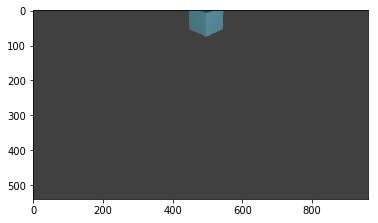

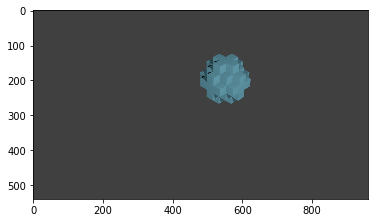

In [4]:
dataset = ToySpheres((9000, 1, 16, 16, 16), 1)

# Create loader with data, so that we can iterate over it
train_loader = torch.utils.data.DataLoader(dataset, batch_size=args['batch_size'], shuffle=True)
# Num batches
num_batches = len(train_loader)

for index in range(2):
    test_sphere = np.squeeze(dataset[index].detach().cpu().numpy())
    visualize3D(test_sphere, title="sample" + str(index), thresh=0.1)
    plt.show()


In [5]:
def swap_halves(x):
    a, b = x.split(x.shape[0]//2)
    return torch.cat([b, a])

# torch.lerp only support scalar weight
def lerp(start, end, weights):
    return start + weights * (end - start)

def L2(x):
    return torch.mean(x**2)

In [6]:
def Encoder():
    return nn.Sequential(
            nn.Conv3d(in_channels = 1, out_channels = 64, kernel_size = 5, stride = 1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # now 14x14x14
            nn.Conv3d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 12x12x12
            nn.MaxPool3d(2, stride=2),
            # 6x6x6
             nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 4x4x4
            nn.Conv3d(in_channels = 16, out_channels = 1, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
            # 2x2x2
        )

def Decoder():
    return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv3d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv3d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding = 2),
            nn.LeakyReLU(0.2),
            nn.Conv3d(in_channels = 16, out_channels = 1, kernel_size = 3, stride = 1),
            nn.Tanh(),
        )

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = torch.mean(x, -1)
        return x

In [7]:
encoder = Encoder().to(args['device'])
decoder = Decoder().to(args['device'])
discriminator = Discriminator().to(args['device'])

opt_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=args['lr'], weight_decay=1e-5)
opt_d = optim.Adam(discriminator.parameters(), lr=args['lr'], weight_decay=1e-5)

In [8]:
sample_data = [dataset[0], dataset[1], dataset[2]]

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Epoch:  0 | autoencoder loss: 0.0690


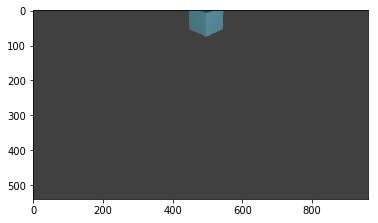

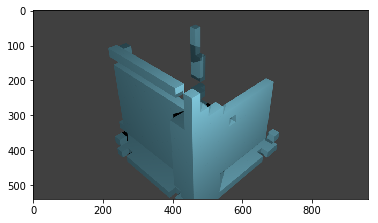

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


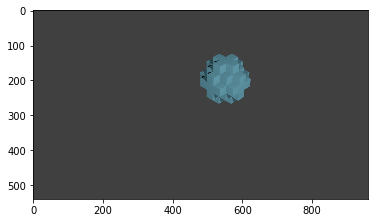

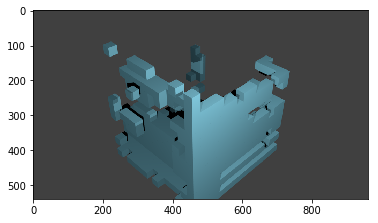

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


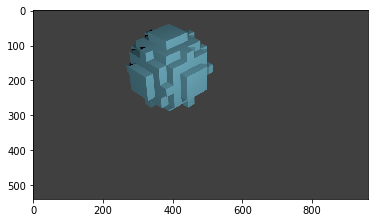

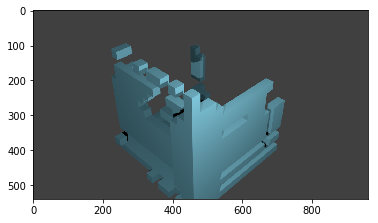

/home/jwaschur-admin/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [9]:
try:
    for epoch in range(args['epochs']):
        for step, (x) in enumerate(train_loader):
            z = encoder(x)
            out = decoder(z)
            disc = discriminator(torch.lerp(out, x, args['reg']))

            alpha = torch.rand(z.size(0), 1, 1, 1, 1).to(args['device']) / 2
            z_mix = lerp(z, swap_halves(z), alpha)
            out_mix = decoder(z_mix)
            disc_mix = discriminator(out_mix)

            loss_ae_mse = F.mse_loss(out, x)
            loss_ae_l2 = L2(disc_mix) * args['advweight']
            loss_ae = loss_ae_mse + loss_ae_l2

            opt_ae.zero_grad()
            loss_ae.backward(retain_graph=True)
            opt_ae.step()

            loss_disc_mse = F.mse_loss(disc_mix, alpha.reshape(-1))
            loss_disc_l2 = L2(disc)
            loss_disc = loss_disc_mse + loss_disc_l2

            opt_d.zero_grad()
            loss_disc.backward()
            opt_d.step()

            if step == 0:
                print('Epoch: ', epoch, '| autoencoder loss: %.4f' % loss_ae.cpu().data.numpy())
                for n in range(3):
                    test_data = sample_data[n].unsqueeze(0)
                    decoded = decoder(encoder(test_data)).detach().cpu().numpy()
                    true_sphere = np.squeeze(test_data.cpu().numpy())
                    visualize3D(true_sphere, title="{}/true/vec_{}/true_e{}_s{}".format(args['testname'], n, epoch, step), percentile=0.85)
                    plt.show()
                    visualize3D(np.squeeze(decoded), title="{}/decoded/vec_{}/decoded_e{}_s{}".format(args['testname'], n, epoch, step), percentile=0.85)
                    plt.show()
except KeyboardInterrupt:
    pass